In [1]:
!pip install seaborn
!pip install nltk
!pip install pyLDAvis
!pip install keras

In [2]:
# Introduction:
# Look at https://github.com/sundeepblue/movie_rating_prediction and download data file movie_metadata.csv.

# Then

 

# Get additional data from other sources if required.
# Perform Data Preprocessing and Exploratory Data Analysis which includes data visualization also.
# Create at least 3 different machine learning models to predict IMDB rating of a movie.
# Compare the results and suggest the model which could be useful to deploy into production.
# Optional: you can also use TensorFlow, Keras or Pytorch to build the models. 
 

# Send your work (code and results and process documentation) as Python notebook output (.html or .ipynb files).
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import plotly.graph_objs as go 
import ast
from plotly.offline import init_notebook_mode,iplot
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline

stemmer = PorterStemmer()
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(CountVectorizer, self).build_analyzer()
        return lambda doc:(stemmer.stem(w) for w in analyzer(doc))

init_notebook_mode(connected=True) 

In [3]:
from google.colab import files
uploaded = files.upload()

# Load the data
movie = pd.read_csv('movie_metadata.csv')
movie.head()



,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


## Exploratary Visualizations


## Notice we see dirty data (NaN values) in first 5 rows
### Categorical Varaibles:
- color
- director_name
- actor_1_name, actor_2_name, actor_3_name
- plot_keywords
- genres ('|' seperated values, encoding needed)
- movie_title
- language
- contry
- content_rating
- title_year

### Numeric Varaibles:
- num_critic_for_reviews
- duration
- director_facebook_likes
- actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
- num_voted_users
- cast_total_facebook_likes
- facenumber_in_poster
- num_user_for_reviews
- imdb_score
- aspect_ratio
- movie_facebook_likes
- budget
- gross

### Variables Categories:

#### Movie One-Hot Variables
- director_name
- actor_1_name, actor_2_name, actor_3_name
- color
- language
- country
- content_rating
- title_year

#### Movie Multi-Hot Variables:
- genres

#### Movie Text Variables:
- movie_title
- plot_keywords

#### Movie Numeric Variables:
- num_critic_for_reviews
- duration
- director_facebook_likes
- actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
- num_voted_users
- cast_total_facebook_likes
- facenumber_in_poster
- num_user_for_reviews
- imdb_score
- aspect_ratio
- movie_facebook_likes

In [0]:
movie.columns
numeric = ['num_critic_for_reviews',
'duration',
'director_facebook_likes',
'actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes',
'num_voted_users',
'cast_total_facebook_likes',
'facenumber_in_poster',
'num_user_for_reviews',
'imdb_score',
'aspect_ratio',
'movie_facebook_likes',
'budget',
'gross']
one_hot = ['director_name',
'actor_1_name', 'actor_2_name', 'actor_3_name',
'color',
'language',
'country',
'content_rating',
'title_year']
multi_hot = ['genres']
text = ['movie_title',
'plot_keywords']

movie_num = movie[numeric]
movie_one = movie[one_hot]
movie_mul = movie[multi_hot]
movie_txt = movie[text]
url = movie[['movie_imdb_link']]

## Imputation

### Numeric Variables:
Impute with KNN imputer after normalized

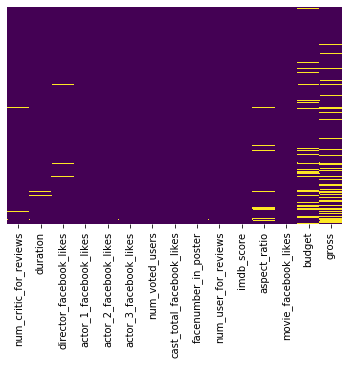

In [5]:
# quick check for null values and decide how to process
# notice many gross is missing

sns.heatmap(movie_num.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

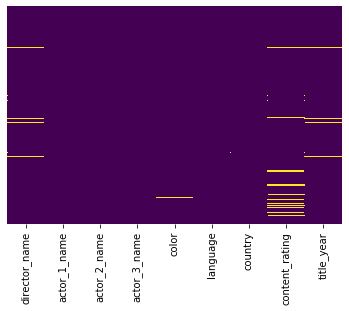

In [6]:
sns.heatmap(movie_one.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

# check null values

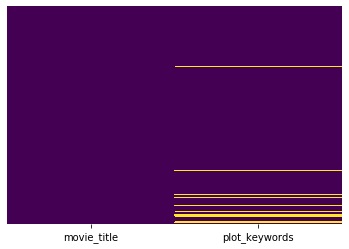

In [7]:
sns.heatmap(movie_txt.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

# check null values

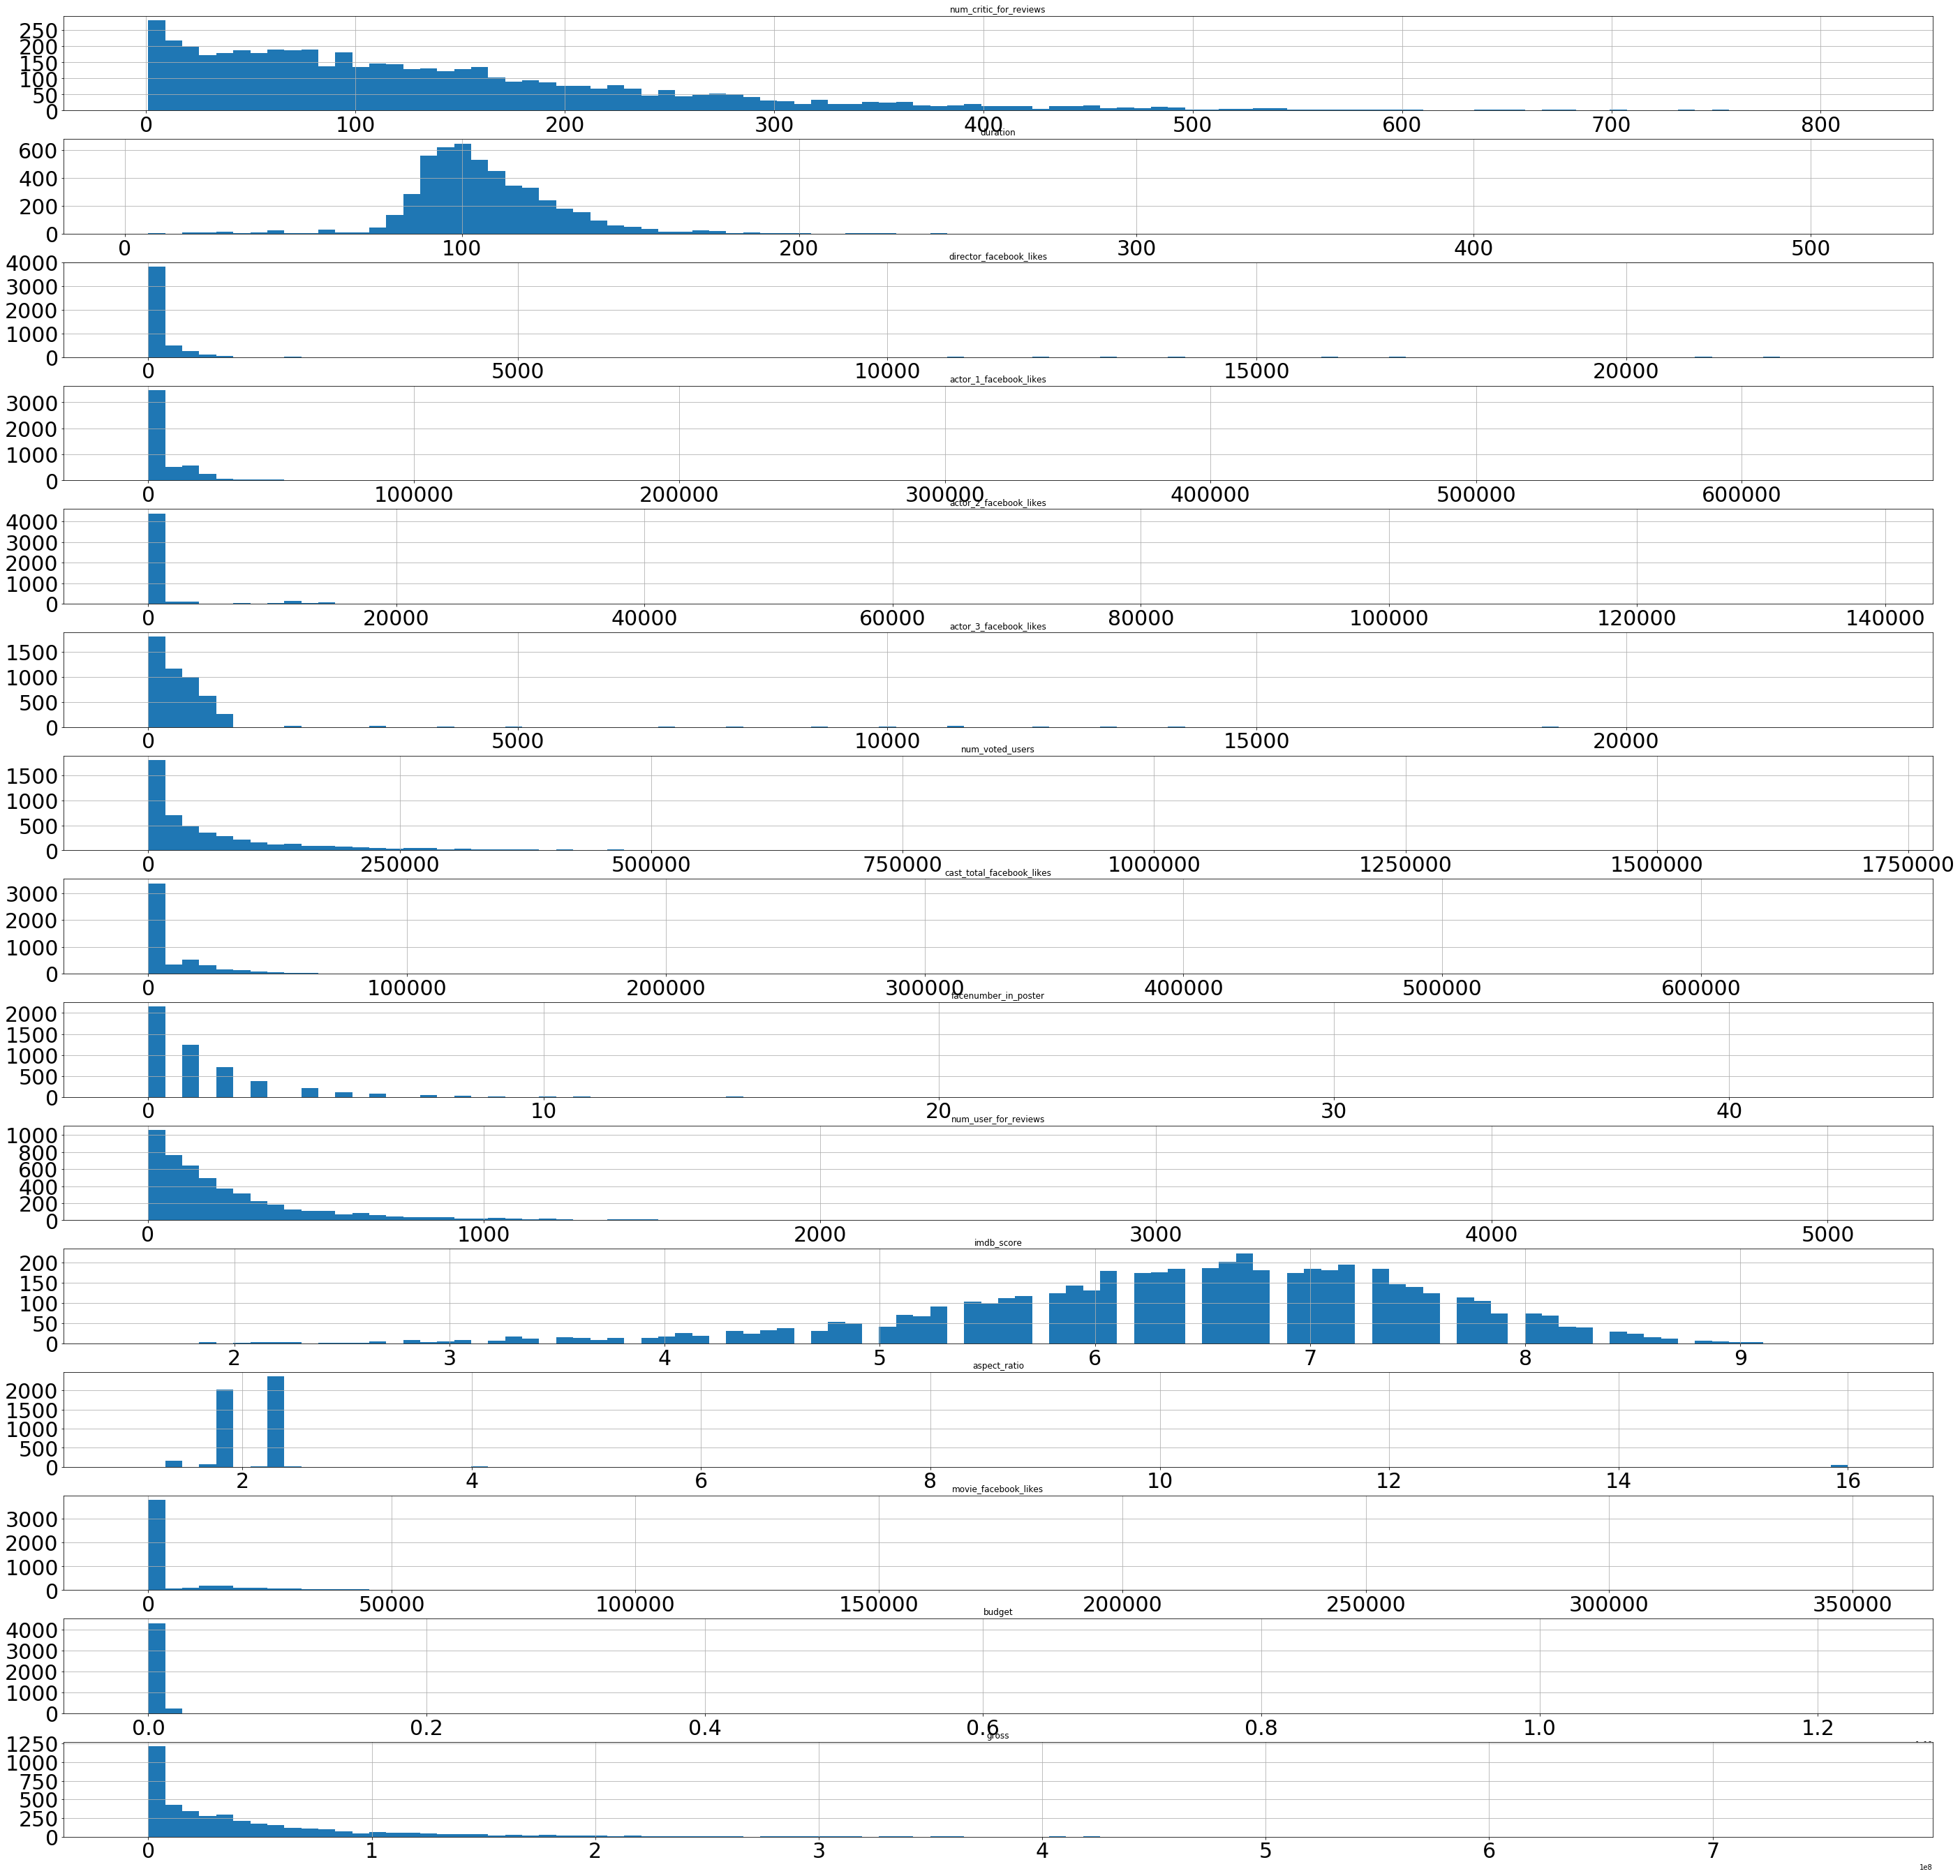

In [8]:
fig, axes = plt.subplots(len(movie_num.columns), 1, figsize=(48, 48))

for col, axis in zip(movie_num.columns, axes):

    movie_num.hist(column = col, bins = 100, ax = axis,xlabelsize = 30,ylabelsize =30)

# check distributions

### Findings:
- columns [2,3,4,5,6,7,8,9,11,12] is long tailed, psudo log transformation
- perform standard scaling after log transformation

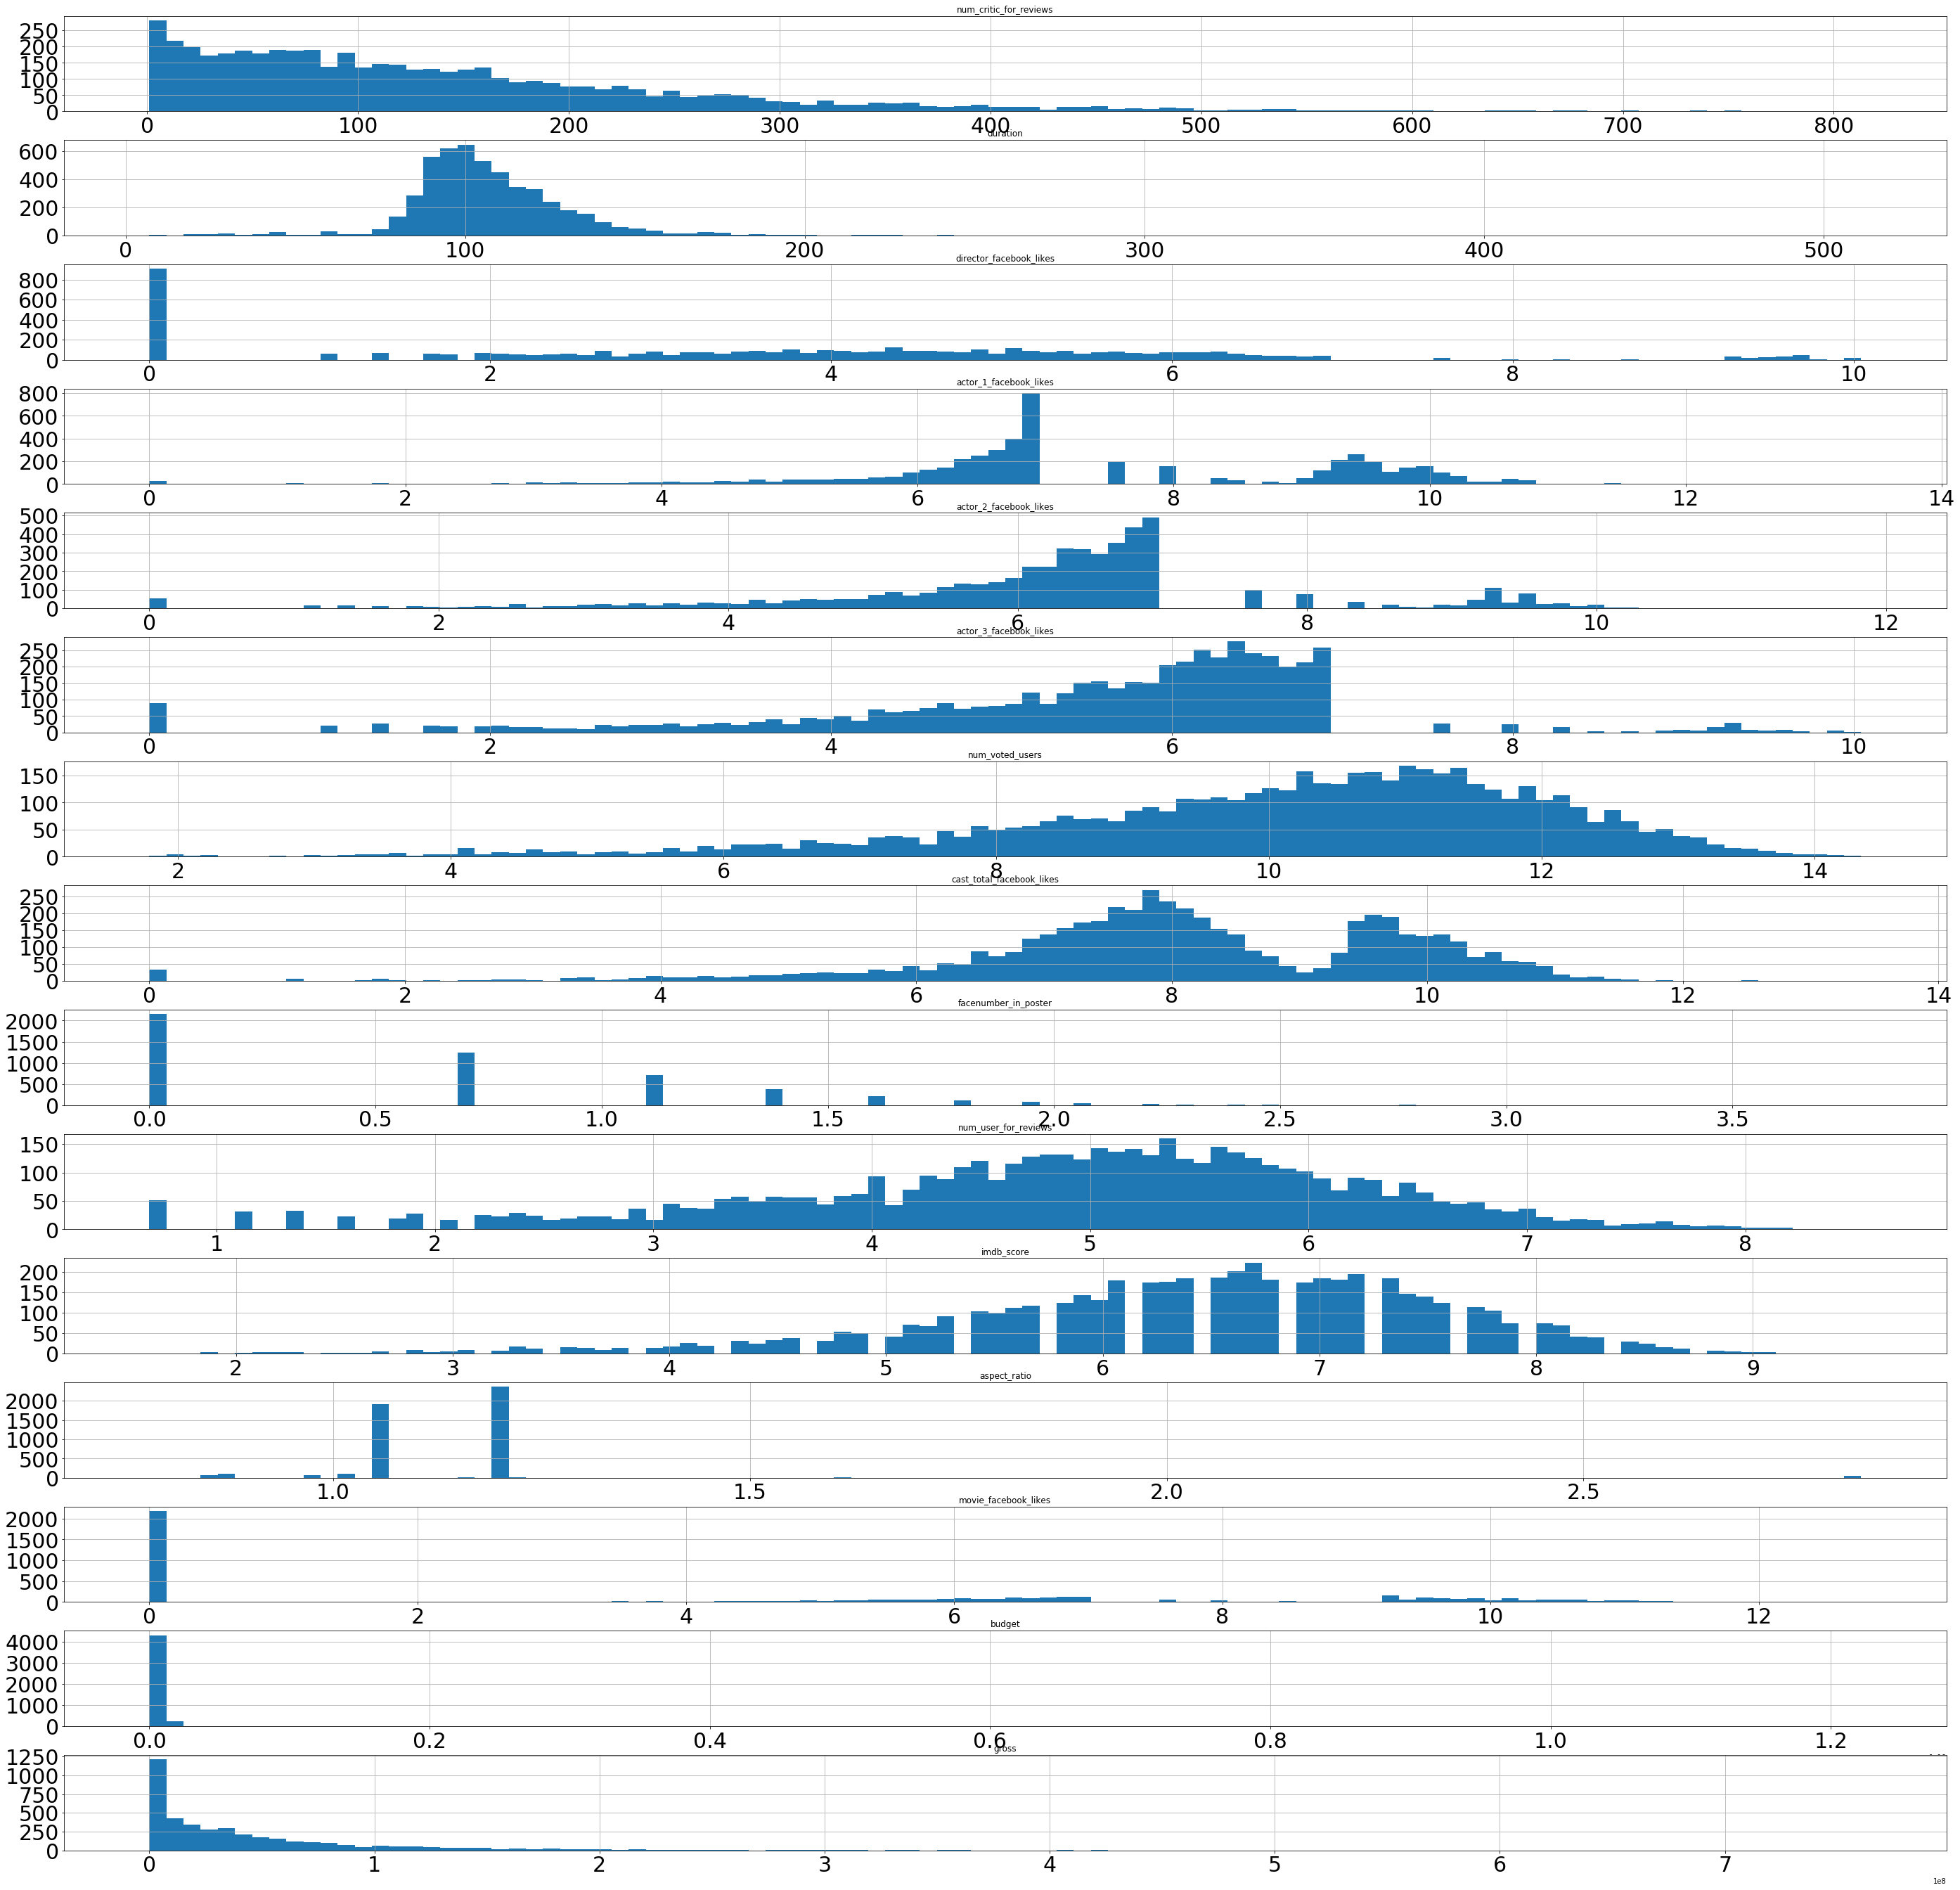

In [9]:
def inverse_log(x):
    return(np.exp(x)-1)

log_transformer = FunctionTransformer(np.log1p,inverse_func=inverse_log)
log_cols = [2,3,4,5,6,7,8,9,11,12]

movie_num_log_transformed = movie_num.copy()

movie_num_log_transformed.iloc[:,log_cols] = log_transformer.transform(movie_num_log_transformed.iloc[:,log_cols])
    

fig, axes = plt.subplots(len(movie_num.columns), 1, figsize=(48, 48))

for col, axis in zip(movie_num.columns, axes):

    movie_num_log_transformed.hist(column = col, bins = 100, ax = axis,xlabelsize = 30,ylabelsize =30)
#transform the data and check distribution again

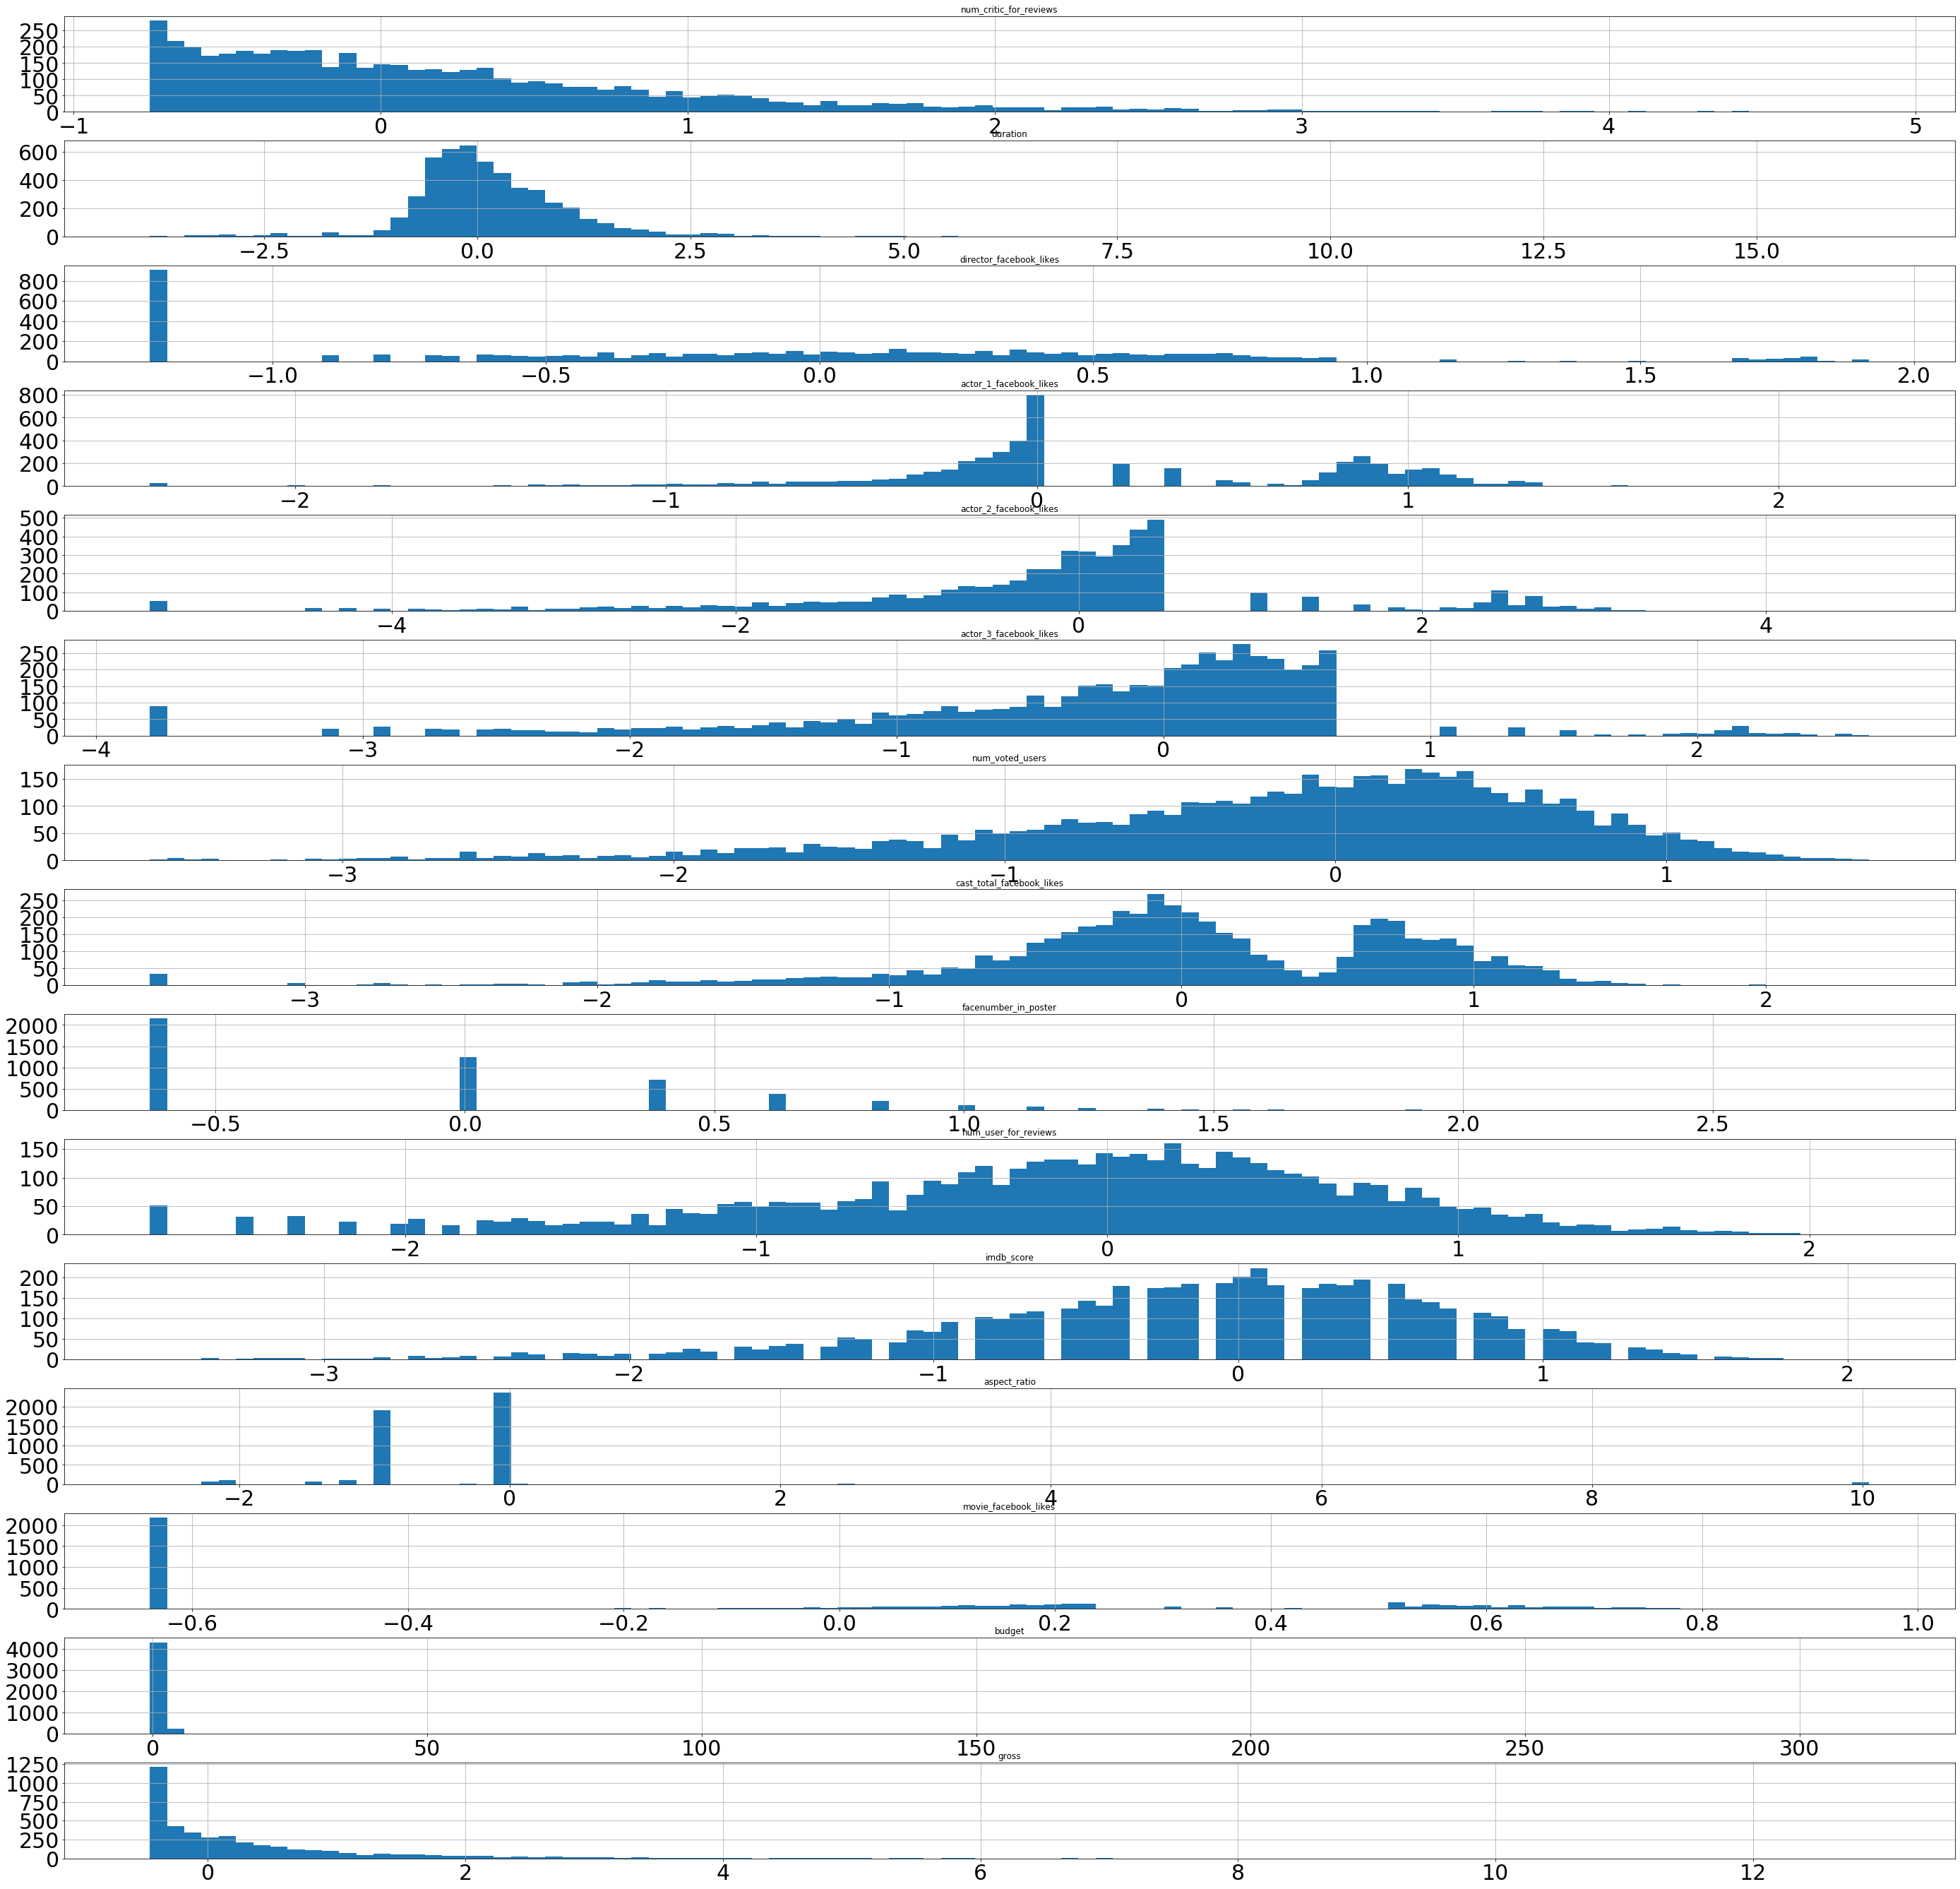

In [10]:
scaler = RobustScaler()
scaler = scaler.fit(movie_num_log_transformed)
movie_num_scaled = pd.DataFrame(scaler.transform(movie_num_log_transformed),columns = movie_num_log_transformed.columns)
fig, axes = plt.subplots(len(movie_num.columns), 1, figsize=(48, 48))
for col, axis in zip(movie_num_scaled.columns, axes):

    movie_num_scaled.hist(column = col, bins = 100, ax = axis,xlabelsize = 30,ylabelsize =30)
#distribution is much normal now

Now data looks much like normal distribution, and we ready to impute the data

In [0]:
imputer = KNNImputer(n_neighbors= 5)
imputer = imputer.fit(movie_num_scaled)
movie_num_imputed_raw = pd.DataFrame(imputer.transform(movie_num_scaled),columns = movie_num.columns)

# use KNN for smart imputing

In [0]:
movie_num_imputed_reversed = pd.DataFrame(scaler.inverse_transform(movie_num_imputed_raw), columns=movie_num.columns)

movie_num_imputed = movie_num_imputed_reversed

movie_num_imputed.iloc[:,log_cols] = log_transformer.inverse_transform(movie_num_imputed.iloc[:,log_cols])
    
movie_num_imputed = pd.DataFrame(movie_num_imputed,columns = movie_num.columns)


# impute numeric values

In [13]:
movie_num_imputed.head()

,num_critic_for_reviews,duration,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,imdb_score,aspect_ratio,movie_facebook_likes,budget,gross
0,723.0,178.0,0.0,1000.0,936.0,855.000000,886204.0,4834.0,0.0,3054.000000,7.9,1.780000,33000.0,237000000.0,760505847.0
1,302.0,169.0,563.0,40000.0,5000.0,1000.000000,471220.0,48350.0,0.0,1238.000000,7.1,2.350000,0.0,300000000.0,309404152.0
2,602.0,148.0,0.0,11000.0,393.0,161.000000,275868.0,11700.0,1.0,994.000000,6.8,2.350000,85000.0,245000000.0,200074175.0
3,813.0,164.0,22000.0,27000.0,23000.0,23000.000000,1144337.0,106759.0,0.0,2701.000000,8.5,2.350000,164000.0,250000000.0,448130642.0
4,8.8,86.4,131.0,131.0,12.0,4.685351,8.0,143.0,0.0,1.786518,7.1,1.920297,0.0,1125650.0,242636.6


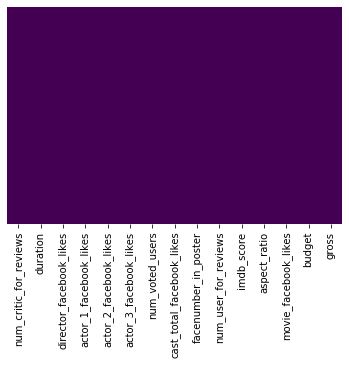

In [14]:
sns.heatmap(movie_num_imputed.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

# no more missing values

### Numeric Cleaning/Transformation Completed

- Data is claned for the numeric part
- Now we move onto encoding of categorical variables
- There are missing values and we use the most_frequent values to impute

In [15]:
imp_freq_one = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_freq_one = imp_freq_one.fit(movie_one)

movie_one_imputed =pd.DataFrame(imp_freq_one.transform(movie_one),columns=movie_one.columns)

movie_one_imputed.head()

#impute categorical values by most_frequent imputer

,director_name,actor_1_name,actor_2_name,actor_3_name,color,language,country,content_rating,title_year
0,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,Color,English,USA,PG-13,2009
1,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,Color,English,USA,PG-13,2007
2,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,Color,English,UK,PG-13,2015
3,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,Color,English,USA,PG-13,2012
4,Doug Walker,Doug Walker,Rob Walker,Ben Mendelsohn,Color,English,USA,R,2009


In [16]:
one_enc = OneHotEncoder(sparse=False)

one_enc = one_enc.fit(movie_one_imputed)

movie_one_encoded =pd.DataFrame(one_enc.transform(movie_one_imputed),columns=one_enc.get_feature_names())

movie_one_encoded.head()

#encode categorical values after imputing

,x0_A. Raven Cruz,x0_Aaron Hann,x0_Aaron Schneider,x0_Aaron Seltzer,x0_Abel Ferrara,x0_Adam Brooks,x0_Adam Carolla,x0_Adam Goldberg,x0_Adam Green,x0_Adam Jay Epstein,x0_Adam Marcus,x0_Adam McKay,x0_Adam Rapp,x0_Adam Rifkin,x0_Adam Shankman,x0_Adrian Lyne,x0_Adrienne Shelly,x0_Agnieszka Holland,x0_Agnieszka Wojtowicz-Vosloo,x0_Agustín Díaz Yanes,x0_Aki Kaurismäki,x0_Akira Kurosawa,x0_Akiva Goldsman,x0_Akiva Schaffer,x0_Al Franklin,x0_Al Silliman Jr.,x0_Alain Resnais,x0_Alan Alda,x0_Alan Cohn,x0_Alan J. Pakula,x0_Alan Jacobs,x0_Alan Metter,x0_Alan Parker,x0_Alan Poul,x0_Alan Rudolph,x0_Alan Shapiro,x0_Alan Taylor,x0_Alan Yuen,x0_Albert Brooks,x0_Albert Hughes,...,x8_1977.0,x8_1978.0,x8_1979.0,x8_1980.0,x8_1981.0,x8_1982.0,x8_1983.0,x8_1984.0,x8_1985.0,x8_1986.0,x8_1987.0,x8_1988.0,x8_1989.0,x8_1990.0,x8_1991.0,x8_1992.0,x8_1993.0,x8_1994.0,x8_1995.0,x8_1996.0,x8_1997.0,x8_1998.0,x8_1999.0,x8_2000.0,x8_2001.0,x8_2002.0,x8_2003.0,x8_2004.0,x8_2005.0,x8_2006.0,x8_2007.0,x8_2008.0,x8_2009.0,x8_2010.0,x8_2011.0,x8_2012.0,x8_2013.0,x8_2014.0,x8_2015.0,x8_2016.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


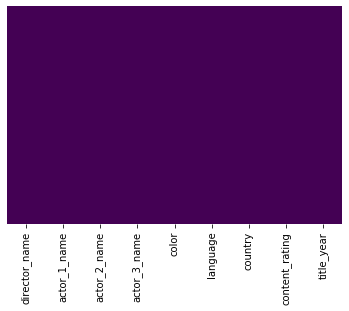

In [17]:
sns.heatmap(movie_one_imputed.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
# no more missing values

In [18]:
imp_freq_mul = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_freq_mul = imp_freq_mul.fit(movie_mul)

movie_mul_imputed =pd.DataFrame(imp_freq_mul.transform(movie_mul),columns=movie_mul.columns)

movie_mul_imputed.head()

#genres

,genres
0,Action|Adventure|Fantasy|Sci-Fi
1,Action|Adventure|Fantasy
2,Action|Adventure|Thriller
3,Action|Thriller
4,Documentary


In [0]:
movie_mul_imputed.genres = pd.Series([set(x) for x in movie_mul_imputed.genres.str.split('|')])
#split into set

In [20]:
enc_mul = MultiLabelBinarizer()
enc_mul = enc_mul.fit(movie_mul_imputed.genres.tolist())
movie_mul_encoded = pd.DataFrame(enc_mul.transform(movie_mul_imputed.genres.tolist()),columns=enc_mul.classes_)
movie_mul_encoded.head()

#transform using multi-hot encoder

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
## movie_text imputing with most_frequent
imp_freq_txt = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_freq_txt = imp_freq_mul.fit(movie_txt)

movie_txt_imputed =pd.DataFrame(imp_freq_txt.transform(movie_txt),columns=movie_txt.columns)

movie_txt_imputed.head()

,movie_title,plot_keywords
0,Avatar,avatar|future|marine|native|paraplegic
1,Pirates of the Caribbean: At World's End,goddess|marriage ceremony|marriage proposal|pi...
2,Spectre,bomb|espionage|sequel|spy|terrorist
3,The Dark Knight Rises,deception|imprisonment|lawlessness|police offi...
4,Star Wars: Episode VII - The Force Awakens ...,based on novel


In [0]:
movie_txt_imputed['full'] = movie_txt_imputed["movie_title"] + movie_txt_imputed["plot_keywords"]
#vectorization of movie_title & keywords


#movie_txt['all'] = movie_txt.movie_title.str movie_txt.plot_keywords.str

## Descriptive Visualizations

- Scatter Plots
- Correlation Matrix

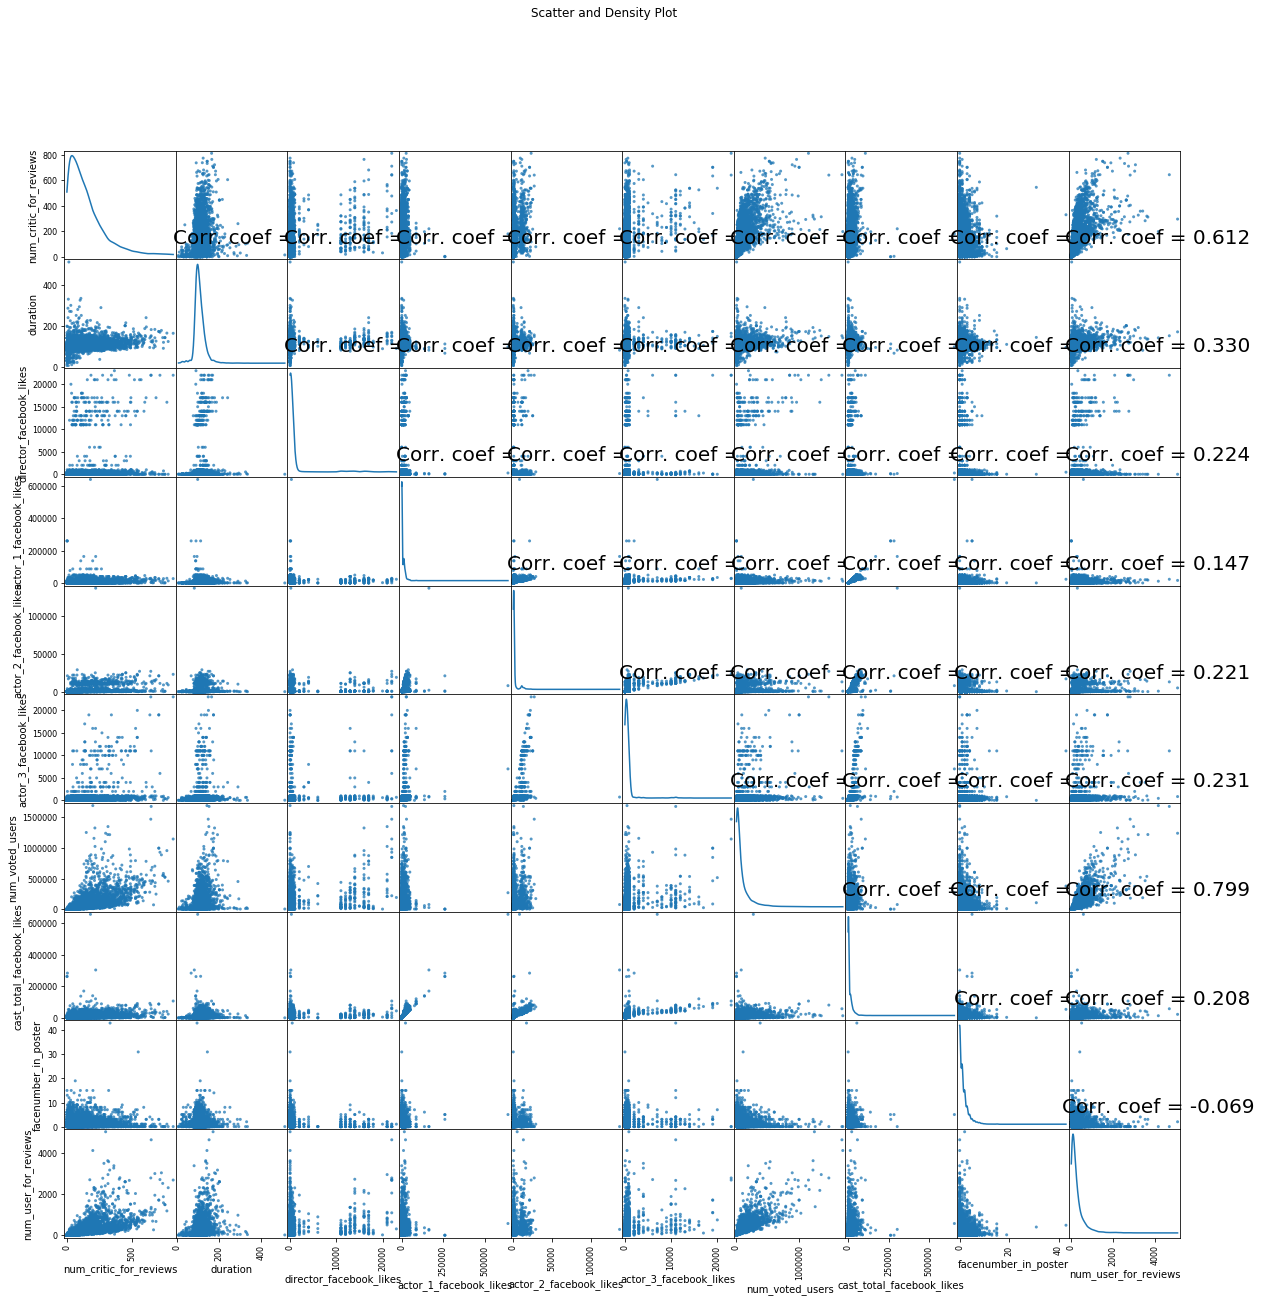

In [23]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()
    
plotScatterMatrix(movie_num_imputed,20,20)
# Check visualization to see the data distributes

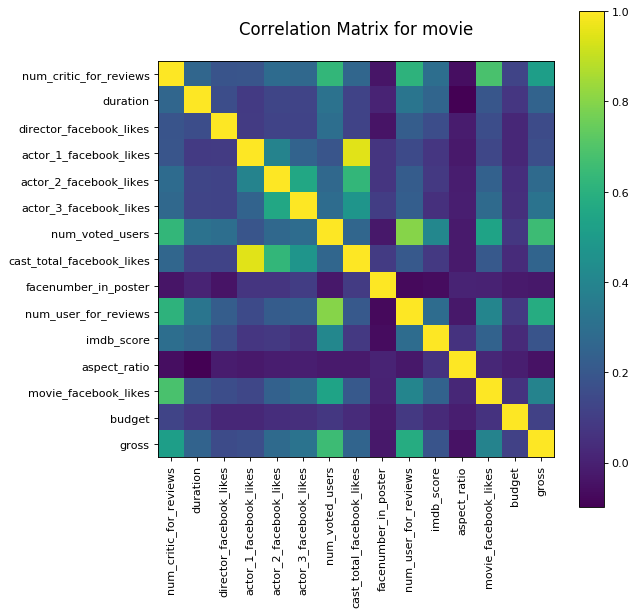

In [24]:
def plotCorrelationMatrix(df, graphWidth):
    filename = 'movie'
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()
plotCorrelationMatrix(movie_num_imputed, 8)

# Check visualization to see the correlation

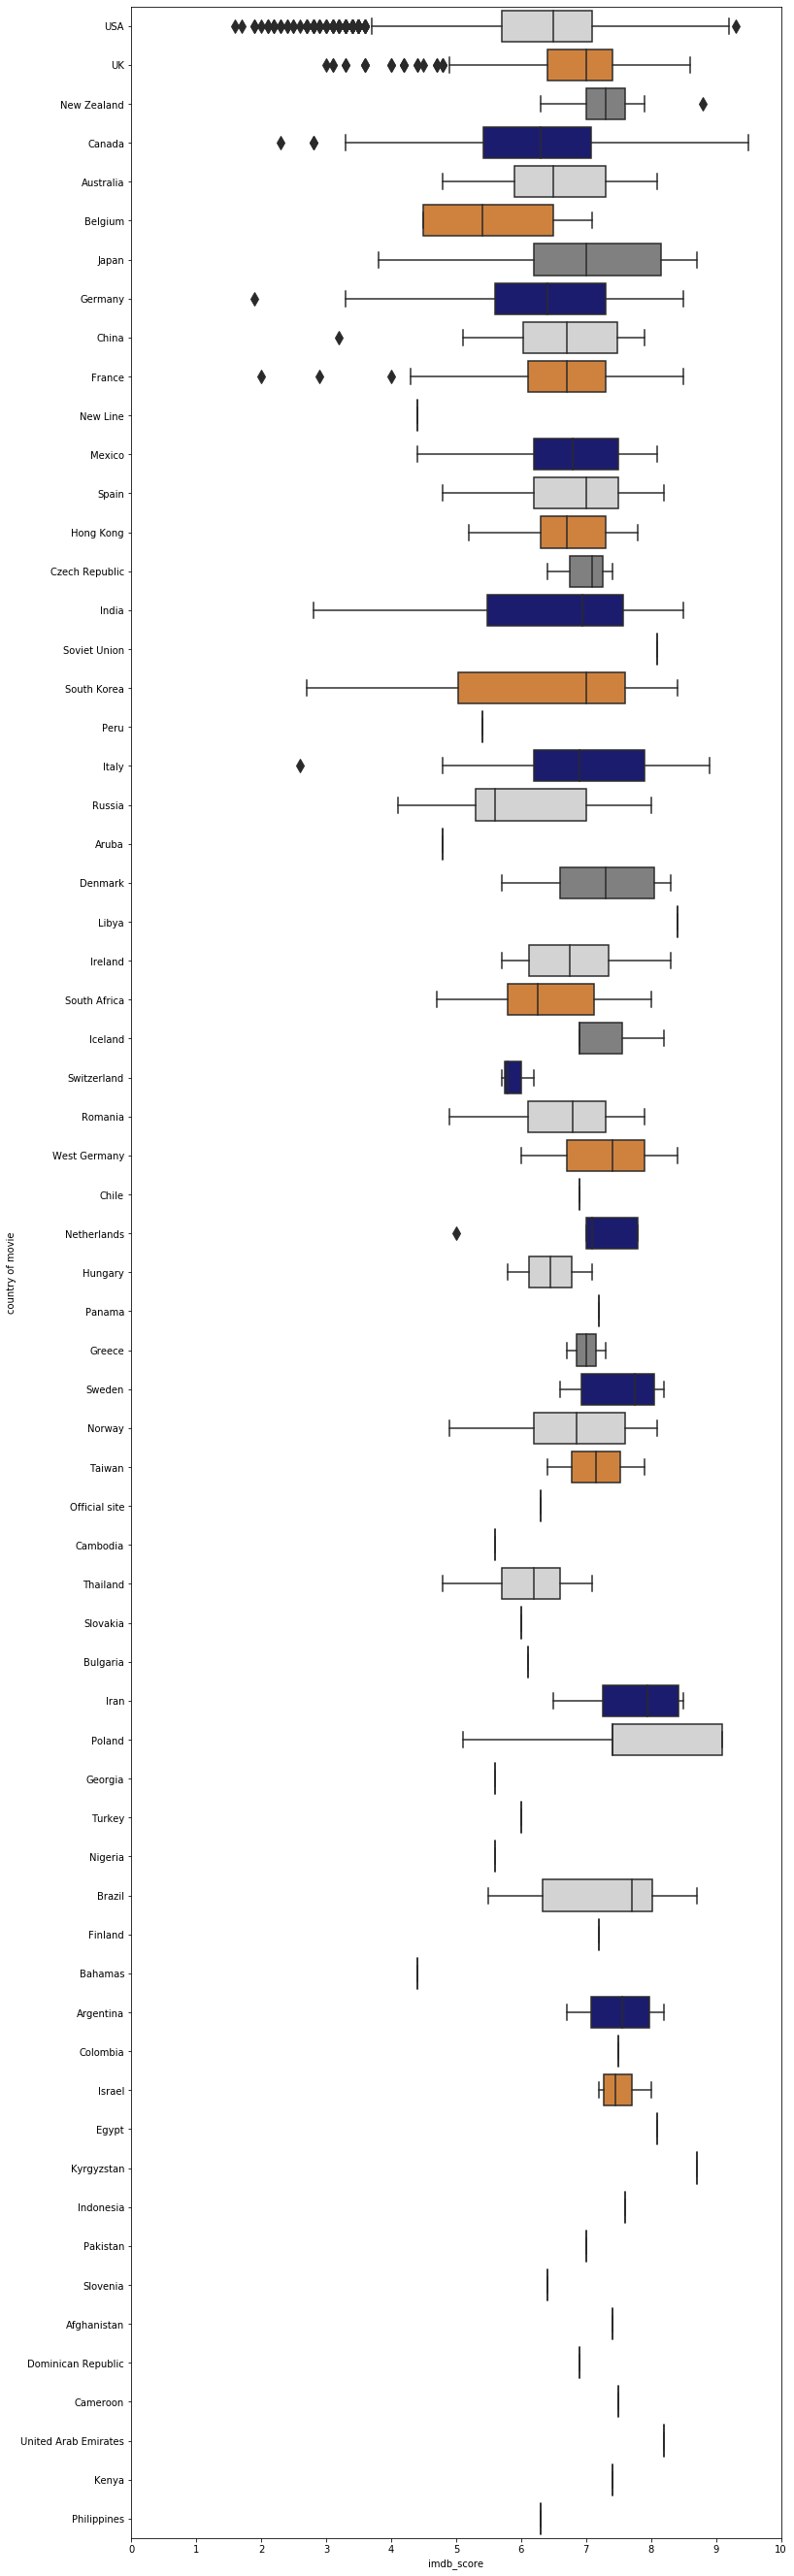

In [25]:
fig, ax = plt.subplots(figsize=(12,48))
p = sns.boxplot("imdb_score", "country", ax=ax,data = movie, saturation = .6, fliersize = 10., palette = ["lightgray", sns.color_palette()[1], "grey", "darkblue"])
_ = p.set(xlabel = "imdb_score", ylabel = "country of movie", xticks = range(11))

# boxplot to see scores distribution by country

In [26]:
def counting_values(df, column):
    value_count = {}
    for row in df[column].dropna():
        if len(row) > 0:
            if row in value_count:
                value_count[row] += 1
            else:
                value_count[row] = 1
        else:
            pass
    return value_count

countries = pd.Series(counting_values(movie, 'country'))

#the map didn't come out so interesting in a regular scale, so I changed it to a logarithmic one:
ln_countries = pd.Series(np.log(countries.values), index = countries.index)

data = dict(type = 'choropleth',
           locations = ln_countries.index,
           locationmode = 'country names',
           colorscale = 'Blackbody',
           text = countries.values,
           z = ln_countries.values,
           colorbar = {'title': 'log of Sum of Movies'})

layout = dict(title = 'Movies Filmed in Countries around the World',
             geo = dict(showframe = False,
                       projection = {'type': 'natural earth'}))

choromap = go.Figure(data = [data],layout = layout)
iplot(choromap,validate=False)

# heatmap for movie count

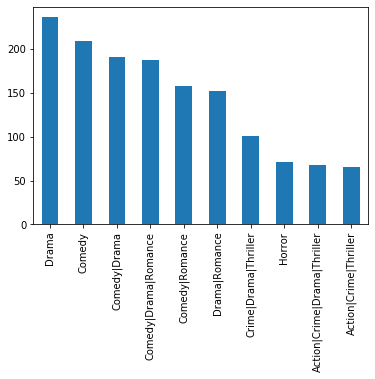

In [27]:
genres_count = pd.Series(counting_values(movie, 'genres'))
genres_count.sort_values(ascending = False).head(10).plot(kind = 'bar')

# genres histogram

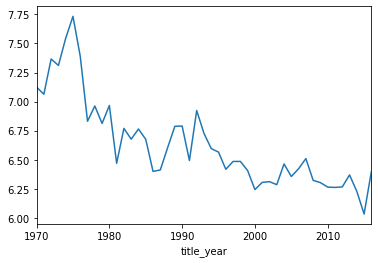

In [28]:
movie[(movie['title_year'] < 2018) & (movie['title_year'] >= 1970)].groupby(by = 'title_year').mean()['imdb_score'].plot()

# average rating of each year from 1970-2019

## Machine Learning

### Regression Method

A simple linear regeression with Dimension Reduction, Recursive Feature Elimination and Cross Validation

### Ensemble Learning
GBM is robust and we grid search best parameters using GridSearchCV

### Neuron Networks
Using Keras for a neural network for regression

In [29]:
fact_table = pd.concat([movie_num_imputed_reversed,movie_one_imputed,movie_mul_imputed,movie_txt_imputed],axis=1)

fact_table.head()

,num_critic_for_reviews,duration,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,imdb_score,aspect_ratio,movie_facebook_likes,budget,gross,director_name,actor_1_name,actor_2_name,actor_3_name,color,language,country,content_rating,title_year,genres,movie_title,plot_keywords,full
0,723.0,178.0,0.0,1000.0,936.0,855.000000,886204.0,4834.0,0.0,3054.000000,7.9,1.780000,33000.0,237000000.0,760505847.0,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,Color,English,USA,PG-13,2009,"{Action, Sci-Fi, Fantasy, Adventure}",Avatar,avatar|future|marine|native|paraplegic,Avatar avatar|future|marine|native|paraplegic
1,302.0,169.0,563.0,40000.0,5000.0,1000.000000,471220.0,48350.0,0.0,1238.000000,7.1,2.350000,0.0,300000000.0,309404152.0,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,Color,English,USA,PG-13,2007,"{Action, Fantasy, Adventure}",Pirates of the Caribbean: At World's End,goddess|marriage ceremony|marriage proposal|pi...,Pirates of the Caribbean: At World's End godde...
2,602.0,148.0,0.0,11000.0,393.0,161.000000,275868.0,11700.0,1.0,994.000000,6.8,2.350000,85000.0,245000000.0,200074175.0,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,Color,English,UK,PG-13,2015,"{Action, Thriller, Adventure}",Spectre,bomb|espionage|sequel|spy|terrorist,Spectre bomb|espionage|sequel|spy|terrorist
3,813.0,164.0,22000.0,27000.0,23000.0,23000.000000,1144337.0,106759.0,0.0,2701.000000,8.5,2.350000,164000.0,250000000.0,448130642.0,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,Color,English,USA,PG-13,2012,"{Action, Thriller}",The Dark Knight Rises,deception|imprisonment|lawlessness|police offi...,The Dark Knight Rises deception|imprisonment|l...
4,8.8,86.4,131.0,131.0,12.0,4.685351,8.0,143.0,0.0,1.786518,7.1,1.920297,0.0,1125650.0,242636.6,Doug Walker,Doug Walker,Rob Walker,Ben Mendelsohn,Color,English,USA,R,2009,{Documentary},Star Wars: Episode VII - The Force Awakens ...,based on novel,Star Wars: Episode VII - The Force Awakens ...


In [0]:
num_input = movie_num_imputed_raw.drop('imdb_score',axis=1)

pca = PCA(n_components=2, svd_solver='full')
pca.fit(num_input)

num_reduced = pca.fit_transform(num_input)



In [0]:
one_input = movie_one_encoded
mul_input = movie_mul_encoded

cat_input = pd.concat([one_input,mul_input],axis=1)

svd = TruncatedSVD(n_components=40, n_iter=7, random_state=42)

cat_reduced = svd.fit_transform(cat_input)

In [0]:
X = np.concatenate([num_reduced,cat_reduced],axis=1)
y = movie_num_imputed['imdb_score']

In [0]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)

In [34]:
# LR with full 42 inputs
estimator = LinearRegression()
estimator.fit(X_train,y_train)
# check r^2
estimator.score(X_test,y_test)

0.27389500355939034

In [35]:
# Check MSE   LR with full 42 inputs
mean_squared_error(y_test, estimator.predict(X_test))

0.8979716721849472

In [36]:
# LR with full 5 inputs selected by RFE
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X_train, y_train)
# check r^2
selector.score(X_test,y_test)


0.10303051680006527

In [37]:
# Check MSE LR with full 5 inputs selected by RFE
mean_squared_error(y_test, selector.predict(X_test))

1.1092792236333189

In [38]:
search_params = {'learning_rate': [0.1, 0.05], 'n_estimators': [100, 50],'max_depth':[3,7]}

# Init the Model
gbm = GradientBoostingRegressor()
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
# Init Grid Search Class
model_grid = GridSearchCV(gbm, param_grid=search_params,cv=cv)

# Do the Grid Search
model_grid.fit(X_train,y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=0, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_sa...
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                

In [39]:
# Check MSE  GBM
mean_squared_error(y_test, model_grid.predict(X_test))

0.8046512003097779

In [40]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor


#X_train, X_test, y_train, y_test = train_test_split(X, y)

model = Sequential()
model.add(Dense(48, input_dim=42, kernel_initializer='normal', activation='softmax'))
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(16, activation='softmax'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 48)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 48)                2352      
_________________________________________________________________
dropout (Dropout)            (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                784       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_______________________________________________________

In [41]:
history = model.fit(X_train, y_train, epochs=150, batch_size=50,  verbose=1, validation_split=0.2)

Train on 3227 samples, validate on 807 samples
Epoch 1/150
3227/3227 [==============================] - 1s 216us/sample - loss: 34.5636 - mean_squared_error: 34.5636 - mean_absolute_error: 5.7707 - val_loss: 33.1657 - val_mean_squared_error: 33.1657 - val_mean_absolute_error: 5.6413
Epoch 2/150
3227/3227 [==============================] - 0s 81us/sample - loss: 32.1675 - mean_squared_error: 32.1676 - mean_absolute_error: 5.5591 - val_loss: 30.5670 - val_mean_squared_error: 30.5670 - val_mean_absolute_error: 5.4060
Epoch 3/150
3227/3227 [==============================] - 0s 80us/sample - loss: 29.7040 - mean_squared_error: 29.7040 - mean_absolute_error: 5.3331 - val_loss: 28.2930 - val_mean_squared_error: 28.2930 - val_mean_absolute_error: 5.1915
Epoch 4/150
3227/3227 [==============================] - 0s 78us/sample - loss: 27.7573 - mean_squared_error: 27.7573 - mean_absolute_error: 5.1476 - val_loss: 26.5238 - val_mean_squared_error: 26.5238 - val_mean_absolute_error: 5.0182
Epoch 5/

In [42]:
# Check MSE  NN
score = model.evaluate(X_test, y_test, batch_size=50)

1009/1009 [==============================] - 0s 36us/sample - loss: 1.2381 - mean_squared_error: 1.2381 - mean_absolute_error: 0.8666


## Best Model:

We did a Training/Testing split of 80% 20%. Performance was measured on testing dataset. 

The model with the best performance is the ensemble model GradientBoostingRegressorl (GBM).

GBM had the lowest MSE 0.80 on test set.

0.80 MSE is reasonably good considering the score range. A good portion of information was kept and a good level of generalization achieved.

LinearRegression is simply not strong enough, and scored 1.10 MSE

NeuronNetworks did not have enough data to train and did not converg well, performed the worst having 1.26 MSE on testing set.